# 訓練情感模型
分析這篇文章中的李＋賢是否有ＡＭＬ風險＿將2-2處理好的300個字資料集進行訓練

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

## 情感分析模型

In [3]:
df = pd.read_csv('step2_2_output_train_data_300.csv')

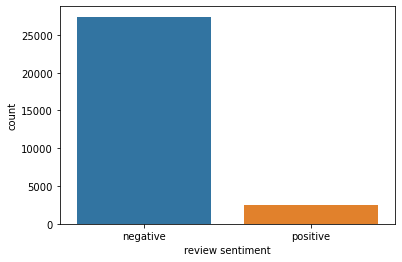

In [4]:
# 正負資料比較及
class_names = ['negative', 'positive']
ax = sns.countplot(df.article_tags)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")#, do_lower_case=False)

In [6]:
sample_txt = df.iloc[0].article_truncate
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: 理財基金量化交易追求絕對報酬 有效對抗牛熊市鉅亨網記者 李家賢2019/07/05 22:35facebook commentFONT SIZEICON PRINT近年來投資市場波動越來越明顯，追求低波動、絕對報酬的量化交易備受注目。專家表示，採用量化交易策略投資台股，不管是處於多頭或是空頭市場，績效及波動度均可領跑大盤，甚至比國內投資台股的股票型基金及 ETF 的波動率還低，表現也更為穩定。大數據時代來臨，風行歐美 50 年的量化交易儼然成為顯學，台灣亦開始重視此一趨勢發展，也因此，中華機率統計學會及台北科技大學管理學院攜手主辦，並由元大期貨、摩根亞太量化交易等公司擔任協
   Tokens: ['理', '財', '基', '金', '量', '化', '交', '易', '追', '求', '絕', '對', '報', '酬', '有', '效', '對', '抗', '牛', '熊', '市', '鉅', '亨', '網', '記', '者', '李', '家', '賢', '2019', '/', '07', '/', '05', '22', ':', '35', '##facebook', '[UNK]', '[UNK]', '[UNK]', '近', '年', '來', '投', '資', '市', '場', '波', '動', '越', '來', '越', '明', '顯', '，', '追', '求', '低', '波', '動', '、', '絕', '對', '報', '酬', '的', '量', '化', '交', '易', '備', '受', '注', '目', '。', '專', '家', '表', '示', '，', '採', '用', '量', '化', '交', '易', '策', '略', '投', '資', '台', '股', '，', '不', '管', '是', '處', '於', '多', '頭', '或', '是', '空', '頭', '市', '場', '，', '績', '效', '及', '波', '動', '度', '均', '可', '領', '跑', '大', '盤', '，', '甚', '至', '比', '國', '內', '投', '資', '台', '股', '的', '股'

In [7]:
MAX_LEN = 300
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [8]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=38
)

In [9]:
df_val = df_test.copy()

In [10]:
df_train.article_tags.value_counts()#0.08869431270014999


0    24657
1     2200
Name: article_tags, dtype: int64

In [11]:
df_test.article_tags.value_counts() #0.09140767824497258


0    2747
1     238
Name: article_tags, dtype: int64

In [12]:
df_test.head()

,article_truncate,article_index,article_tags,article_tags_name
14768,美國聯邦眾議院上月針對烏克蘭「電話門」向總統李家賢展開彈劾調查，美國國防部長艾斯培今天則表示...,2247,0,川普
28192,｜欒昀茜、鄭雅紋 全文朗讀 00:00 / 00:00黃乃文用裝釣具的塑膠套...,4340,0,李建穎
4136,〔記者張瑞楨、李家賢／台中報導〕台南市17歲少女小珍（化名），本月14日參加性愛毒趴猝死，何...,651,0,吳俊鋒
12557,娛樂頭條2019.11.04 16:34李家賢扮同志icon甩人生低潮明年再搶小金人文｜熊景...,1934,0,芮妮齊薇格
7098,20天內核定，但經政委李家賢建議後，會把20天限制刪掉；此外，在草案說明欄內的第二次審議結果...,1082,0,林萬億


In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    reviews=df.article_truncate.to_numpy(),
    targets=df.article_tags.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
    )

In [14]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
PRE_TRAINED_MODEL_NAME = "bert-base-chinese"

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [16]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [18]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [19]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [20]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


In [ ]:
# save model
import os 
PATH = os.getcwd()+str('/step3_output_bert_senti.pth')
torch.save(model, PATH)

In [ ]:
PATH = os.getcwd()+str('/step3_output_bert_senti.pth')

model2 = torch.load(PATH)
model2.eval()

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [72]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
#test_acc.item()

In [73]:
test_acc.item() #0.9728643216080403


0.9728643216080403

In [74]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [75]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [76]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.98      0.99      0.99      2735
    positive       0.87      0.80      0.83       250

    accuracy                           0.97      2985
   macro avg       0.93      0.89      0.91      2985
weighted avg       0.97      0.97      0.97      2985



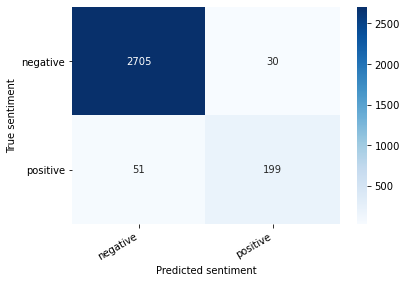

In [77]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [87]:
idx = 7
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

人頭，詐領每個月8萬元助理費用，共詐領429萬1235元。全案檢方偵結，認事證明確，依法起訴李家賢及李家賢的哥哥、兒子與嫂子等4人。

True sentiment: positive


In [86]:
df_test2 = df_test.reset_index()#[df_test.article_tags==1]
df_test2[df_test2.article_tags==1]

,index,article_truncate,article_index,article_tags,article_tags_name
7,6153,人頭，詐領每個月8萬元助理費用，共詐領429萬1235元。全案檢方偵結，認事證明確，依法起訴...,971,1,陳孝仁
15,6732,▲國安局少校吳宗憲被移送北檢時的畫面。（圖／記者劉昌松攝）記者黃翊婷／綜合報導國安局少校吳宗...,1043,1,張恒嘉
25,13478,去買飲料。蔡鎧陽離開後，陳男隨即掏槍壓制蔡宗育，企圖奪走現金，但現金不在車上。陳男命蔡宗育打...,2057,1,陳威宇
28,19087,。檢調另查出，王毓雅以不實交易，作假帳方式向國稅局申報退稅，詐取退稅款26萬多元。檢調指出，...,2937,1,羅瑞榮
34,11534,「開元國際企業」負責人李家賢，涉嫌以人頭購買凶宅、瑕疵屋，製作不實買賣契約將交易價格灌水，再...,1752,1,李榮華
...,...,...,...,...,...
2904,8542,釋！那時候覺得這輩子遇到他們，真是倒八輩子的楣！」阿青沮喪地說：「我們不只把錢給他，連人也給...,1283,1,楊雲傑
2920,17415,，違反證交法而遭到「解職」者，未來三年都不得回任金融業任職，範圍包含銀行、保險及證券業都不行...,2689,1,林冠百
2935,15871,負責人李保承賄賂。台北地檢署依收賄、洗錢等罪嫌起訴林錫山、李保承、立法院秘書室科長陳亮吟及林...,2427,1,劉馨蔚
2946,21270,，餘款是存在聯昇公司帳戶，與張國安歷次所稱欲賺取價差獲利的目的不同，可知本件交易最大受益者是...,3280,1,陳淑珠


In [93]:
pd.Series(np.array(y_test)).value_counts()

0    2735
1     250
dtype: int64

In [97]:
y_pred_probs

tensor([[ 4.4158, -4.7524],
        [ 4.4105, -4.8092],
        [ 4.4153, -4.7372],
        ...,
        [ 4.4143, -4.7256],
        [ 4.4028, -4.8315],
        [ 4.4092, -4.8109]])

In [124]:
pd.DataFrame(np.array(y_pred_probs.tolist())).min()

0   -2.115338
1   -4.848463
dtype: float64

In [125]:
pd.DataFrame(np.array(y_pred_probs.tolist())).max()

0    4.417915
1    2.802731
dtype: float64

# 預測

In [9]:
# Model class must be defined somewhere
PATH = 'step3_output_bert_senti.pth'
model2 = torch.load(PATH)
model2.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [18]:
review_text = "富二代網路警察李家賢查獲一間詐騙集團，協助玉山銀行進行洗錢防制"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=100,#MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [19]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model2(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: 富二代網路警察李家賢查獲一間詐騙集團，協助玉山銀行進行洗錢防制
Sentiment  : positive


In [135]:
prediction.tolist()[0]

1

In [101]:
np.sum(output)

tensor([[-2.1026,  2.7980]], device='cuda:0', grad_fn=<AddmmBackward>)

In [117]:
np.sum(np.array(output.tolist()).squeeze())

0.6954159736633301

In [102]:
a, prediction = torch.max(output, dim=1)

In [107]:
df_test2.head()

,index,article_truncate,article_index,article_tags,article_tags_name
0,14768,管理及預算局（Office of Management and Budget）發出傳票，要求...,2247,0,川普
1,28192,.09 05:58【愛我就殺我老公1】七夕揪小鮮肉床戰3回合甜美嫩媳蛇蠍殺夫文｜林慶祥繪圖｜...,4340,0,鄭雅紋
2,4136,〔記者張瑞楨、李家賢／台中報導〕台南市17歲少女小珍（化名），本月14日參加性愛毒趴猝死，何...,651,0,吳俊鋒
3,12557,低潮，最慘的是她2014年久休再出現，一張看似衰老變形的臉飽受嘲弄。她接下詮釋好萊塢頭號「同...,1934,0,茱蒂
4,7098,s表示，本會期行政院沒提出優先法案清單，此會期很短，且過去許多法案已在立法院各委員會審查中，...,1082,0,蘇貞昌


In [136]:
predict=[]

for i in range(len(df_test2)):
    review_text = df_test2.iloc[i].article_truncate
    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    predict.append( prediction.tolist()[0] ) 
    #predict.append( np.sum(np.array(output.tolist()).squeeze()) )

In [138]:
len(predict)

2985

In [139]:
len(df_test2)

2985

In [141]:
df_test2['predict'] = predict

In [146]:
group_test =df_test2[['article_index','article_tags','article_tags_name','predict']].groupby(['article_index','article_tags_name']).mean()

In [149]:
group_test.predict.value_counts()

0.000000    2235
1.000000     183
0.500000       7
0.666667       2
0.333333       1
Name: predict, dtype: int64

In [164]:
group_test.reset_index(inplace=True)

In [168]:
uniq_article = np.unique(group_test.article_index.values) # 文章獨一無二的量

In [181]:
group_test[(group_test.article_index==2)&(group_test.article_tags==1)].article_tags_name.tolist()

[]

In [178]:
group_test

,article_index,article_tags_name,article_tags,predict
0,2,凱德唐,0.0,0.0
1,2,君鴻,0.0,0.0
2,4,邱花妹,0.0,0.0
3,4,陳其邁,0.0,0.0
4,5,任正非,0.0,0.0
...,...,...,...,...
2423,4590,邵家臻,0.0,0.0
2424,4591,鍾美君,0.0,0.0
2425,4594,杜思德,0.0,0.0
2426,4597,南海,0.0,0.0


In [187]:
predd_list = []
answer_list = []
for i in uniq_article:
    print('article:{f}'.format(f = i))
    predd = group_test[(group_test.article_index==i)&(group_test.predict>=0.5)].article_tags_name.tolist()
    predd_list.append(predd)
    print('預測 = '+str(predd))
    
    
    answer = group_test[(group_test.article_index==i)&(group_test.article_tags==1)].article_tags_name.tolist()
    print('答案 = '+str(answer))
    answer_list.append(answer)

article:2
預測 = []
答案 = []
article:4
預測 = []
答案 = []
article:5
預測 = []
答案 = []
article:6
預測 = []
答案 = []
article:15
預測 = ['王派宏']
答案 = ['王派宏']
article:19
預測 = []
答案 = []
article:21
預測 = []
答案 = []
article:28
預測 = []
答案 = []
article:31
預測 = []
答案 = []
article:34
預測 = ['李威儀']
答案 = ['李威儀', '王桂霜']
article:37
預測 = []
答案 = []
article:39
預測 = []
答案 = []
article:41
預測 = []
答案 = []
article:48
預測 = []
答案 = []
article:49
預測 = []
答案 = []
article:52
預測 = []
答案 = []
article:59
預測 = []
答案 = []
article:62
預測 = []
答案 = []
article:64
預測 = []
答案 = []
article:67
預測 = ['安東尼羅賓']
答案 = []
article:74
預測 = []
答案 = []
article:80
預測 = []
答案 = []
article:82
預測 = []
答案 = []
article:86
預測 = []
答案 = []
article:87
預測 = []
答案 = []
article:88
預測 = ['鄭博文']
答案 = ['鄭博文']
article:89
預測 = []
答案 = []
article:92
預測 = []
答案 = []
article:93
預測 = []
答案 = []
article:97
預測 = []
答案 = []
article:98
預測 = []
答案 = []
article:100
預測 = ['宋楚瑜']
答案 = ['楚瑞芳']
article:105
預測 = []
答案 = []
article:108
預測 = []
答案 = []
article:113
預測 = []
答案 = []
a

In [193]:
predd_list = []
answer_list = []
for i in uniq_article:
    print('article:{f}'.format(f = i))
    predd = group_test[(group_test.article_index==i)&(group_test.predict>=0.2)].article_tags_name.tolist()
    predd_list.append(predd)
    print('預測 = '+str(predd))
    
    
    answer = group_test[(group_test.article_index==i)&(group_test.article_tags==1)].article_tags_name.tolist()
    print('答案 = '+str(answer))
    answer_list.append(answer)

article:2
預測 = []
答案 = []
article:4
預測 = []
答案 = []
article:5
預測 = []
答案 = []
article:6
預測 = []
答案 = []
article:15
預測 = ['王派宏']
答案 = ['王派宏']
article:19
預測 = []
答案 = []
article:21
預測 = []
答案 = []
article:28
預測 = []
答案 = []
article:31
預測 = []
答案 = []
article:34
預測 = ['李威儀']
答案 = ['李威儀', '王桂霜']
article:37
預測 = []
答案 = []
article:39
預測 = []
答案 = []
article:41
預測 = []
答案 = []
article:48
預測 = []
答案 = []
article:49
預測 = []
答案 = []
article:52
預測 = []
答案 = []
article:59
預測 = []
答案 = []
article:62
預測 = []
答案 = []
article:64
預測 = []
答案 = []
article:67
預測 = ['安東尼羅賓']
答案 = []
article:74
預測 = []
答案 = []
article:80
預測 = []
答案 = []
article:82
預測 = []
答案 = []
article:86
預測 = []
答案 = []
article:87
預測 = []
答案 = []
article:88
預測 = ['鄭博文']
答案 = ['鄭博文']
article:89
預測 = []
答案 = []
article:92
預測 = []
答案 = []
article:93
預測 = []
答案 = []
article:97
預測 = []
答案 = []
article:98
預測 = []
答案 = []
article:100
預測 = ['宋楚瑜']
答案 = ['楚瑞芳']
article:105
預測 = []
答案 = []
article:108
預測 = []
答案 = []
article:113
預測 = []
答案 = []
a

In [197]:
predd_list = []
answer_list = []
for i in uniq_article:
    print('article:{f}'.format(f = i))
    predd = group_test[(group_test.article_index==i)&(group_test.predict>=1.0)].article_tags_name.tolist()
    predd_list.append(predd)
    print('預測 = '+str(predd))
    
    
    answer = group_test[(group_test.article_index==i)&(group_test.article_tags==1)].article_tags_name.tolist()
    print('答案 = '+str(answer))
    answer_list.append(answer)

article:2
預測 = []
答案 = []
article:4
預測 = []
答案 = []
article:5
預測 = []
答案 = []
article:6
預測 = []
答案 = []
article:15
預測 = ['王派宏']
答案 = ['王派宏']
article:19
預測 = []
答案 = []
article:21
預測 = []
答案 = []
article:28
預測 = []
答案 = []
article:31
預測 = []
答案 = []
article:34
預測 = ['李威儀']
答案 = ['李威儀', '王桂霜']
article:37
預測 = []
答案 = []
article:39
預測 = []
答案 = []
article:41
預測 = []
答案 = []
article:48
預測 = []
答案 = []
article:49
預測 = []
答案 = []
article:52
預測 = []
答案 = []
article:59
預測 = []
答案 = []
article:62
預測 = []
答案 = []
article:64
預測 = []
答案 = []
article:67
預測 = ['安東尼羅賓']
答案 = []
article:74
預測 = []
答案 = []
article:80
預測 = []
答案 = []
article:82
預測 = []
答案 = []
article:86
預測 = []
答案 = []
article:87
預測 = []
答案 = []
article:88
預測 = ['鄭博文']
答案 = ['鄭博文']
article:89
預測 = []
答案 = []
article:92
預測 = []
答案 = []
article:93
預測 = []
答案 = []
article:97
預測 = []
答案 = []
article:98
預測 = []
答案 = []
article:100
預測 = ['宋楚瑜']
答案 = ['楚瑞芳']
article:105
預測 = []
答案 = []
article:108
預測 = []
答案 = []
article:113
預測 = []
答案 = []
a

In [188]:
def score(truth, predict):
    if truth == [] and predict != []:
        return 0
    
    if truth != [] and predict == []:
        return 0
    
    if truth == [] and predict == []:
        return 1
    
    recall = len([i for i in truth if i in predict])/len(truth)
    precision = len([i for i in predict if i in truth])/len(predict)
    
    try:
        return 2/((1/recall)+(1/precision))
    except:
        return 0

In [192]:
score(answer_list, predd_list)0.6

0.9746667541451457

In [194]:
score(answer_list, predd_list)0.2

0.9743553617031184

In [196]:
score(answer_list, predd_list)#0.8

0.974964708940522

In [201]:
predict=[]

for i in range(len(df_test2)):
    review_text = df_test2.iloc[i].article_truncate
    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model2(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    predict.append( prediction.tolist()[0] ) 
    #predict.append( np.sum(np.array(output.tolist()).squeeze()) )

In [202]:
df_test2['predict'] = predict
group_test =df_test2[['article_index','article_tags','article_tags_name','predict']].groupby(['article_index','article_tags_name']).mean()

In [203]:
group_test.reset_index(inplace=True)
uniq_article = np.unique(group_test.article_index.values) # 文章獨一無二的量

In [204]:
predd_list = []
answer_list = []
for i in uniq_article:
    print('article:{f}'.format(f = i))
    predd = group_test[(group_test.article_index==i)&(group_test.predict>=0.5)].article_tags_name.tolist()
    predd_list.append(predd)
    print('預測 = '+str(predd))
    
    
    answer = group_test[(group_test.article_index==i)&(group_test.article_tags==1)].article_tags_name.tolist()
    print('答案 = '+str(answer))
    answer_list.append(answer)

article:2
預測 = []
答案 = []
article:4
預測 = []
答案 = []
article:5
預測 = []
答案 = []
article:6
預測 = []
答案 = []
article:15
預測 = ['王派宏']
答案 = ['王派宏']
article:19
預測 = []
答案 = []
article:21
預測 = []
答案 = []
article:28
預測 = []
答案 = []
article:31
預測 = []
答案 = []
article:34
預測 = ['李威儀']
答案 = ['李威儀', '王桂霜']
article:37
預測 = []
答案 = []
article:39
預測 = []
答案 = []
article:41
預測 = []
答案 = []
article:48
預測 = []
答案 = []
article:49
預測 = []
答案 = []
article:52
預測 = []
答案 = []
article:59
預測 = []
答案 = []
article:62
預測 = []
答案 = []
article:64
預測 = []
答案 = []
article:67
預測 = ['安東尼羅賓']
答案 = []
article:74
預測 = []
答案 = []
article:80
預測 = []
答案 = []
article:82
預測 = []
答案 = []
article:86
預測 = []
答案 = []
article:87
預測 = []
答案 = []
article:88
預測 = ['鄭博文']
答案 = ['鄭博文']
article:89
預測 = []
答案 = []
article:92
預測 = []
答案 = []
article:93
預測 = []
答案 = []
article:97
預測 = []
答案 = []
article:98
預測 = []
答案 = []
article:100
預測 = ['宋楚瑜']
答案 = ['楚瑞芳']
article:105
預測 = []
答案 = []
article:108
預測 = []
答案 = []
article:113
預測 = []
答案 = []
a

In [205]:
score(answer_list, predd_list)#0.2

0.9746667541451457